## requirements.txt

In [1]:
!pip freeze > requirements.txt
# !pip install -r requirements.txt

## Загрузка библиотек и зависимостей

In [1]:
import time
import pandas as pd
import numpy as np

from tqdm import tqdm, trange
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import tsfresh as tsf
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series

In [3]:
# Imbalanced Dependencies
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier

# Under/Over Sampling
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE

## Загрузка данных

In [4]:
# Загружаем обучающие и тестовые данные. Также сабмит для отправки
df_train = pd.read_parquet("DCS/Train/hackaton2023_train.gzip")
df_test = pd.read_parquet("DCS/Test/hackaton2023_test.gzip")
submit = pd.read_csv("DCS/submission.csv", sep=';')

df_train.shape, df_test.shape

((12129384, 9), (2498034, 7))

In [5]:
# Загружаем данные из локальной базы данных по различным запросам из файла ''
# db_features = pd.read_parquet("DCS/Features/first_features.parquet")

|     Название                |     Описание                                                                             |     Тип   переменной    |     Комментарий                |   |
|-----------------------------|------------------------------------------------------------------------------------------|-------------------------|--------------------------------|---|
|     customer_id             |     Идентификатор   клиента                                                              |     int                 |                                |   |
|     group_name              |     Группа:   train (обучение) – test(контроль)                                          |                         |                                |   |
|     revenue                 |     Выручка   от продажи блюда в заказе                                                  |     float               |                                |   |
|     startdatetime           |     Дата   и время продажи                                                               |     datetime            |                                |   |
|     dish_name               |     Название   блюда                                                                     |     string              |                                |   |
|     ownareaall_sqm          |     Площадь   ресторана                                                                  |     float               |                                |   |
|     format_name             |     Формат   ресторана                                                                   |                         |                                |   |
|     buy_post                |     Таргет   1: флаг оттока     (0 – отток, 1 – не отток)                                |     bool                |     Только   в train данных    |   |
|     date_diff_post          |     Таргет   2: количество дней между последней покупкой в прошлом и первой в будущем    |     int                 |     Только   в train данных    |   |

In [6]:
df_train.head(7)

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
0,29891,9.0,1,train,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны
1,29891,9.0,1,train,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны
2,29891,9.0,1,train,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны
3,29891,9.0,1,train,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны
4,29891,9.0,1,train,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны
5,29891,9.0,1,train,60.00,2022-12-15 00:37:19,Чизбургер,463.0,Отдельно стоящий с внешней зоной
6,29891,9.0,1,train,209.99,2022-12-15 00:37:19,Воппер Ролл,463.0,Отдельно стоящий с внешней зоной


## EDA

In [7]:
# Распределение таргета
target_d = pd.DataFrame(df_train['buy_post'].value_counts())
target_d

,count
buy_post,
1,9660867
0,2468517


In [8]:
# Проверка на новых пользователей в тестовой выборке
train_customers = set(df_train['customer_id'].unique().tolist())
test_customers = set(df_test['customer_id'].unique().tolist())

assert len(train_customers - test_customers) == len(train_customers), "Клиенты в трейне не повторяются!"
assert len(test_customers - train_customers) == len(test_customers), "Клиенты в тесте не повторяются!"

# Делаем вывод, что для валидации нужно брать клиентов не из обучающей выборке

## Обработка данных

In [9]:
# Объединяем данные
data = pd.concat([df_train, df_test])

In [10]:
# Сортируем по ID клиента и по дате транзакции
data = data.sort_values(by=['customer_id', 'startdatetime'], ascending=True)

In [11]:
# Выделяем признаки из времени
data['day'] = data['startdatetime'].dt.day
data['day_of_week'] = data['startdatetime'].dt.day_of_week
data['weekday'] = data['startdatetime'].dt.weekday
data['hour'] = data['startdatetime'].dt.hour

In [12]:
train_data = data[data['group_name'] == 'train']
test_data = data[data['group_name'] == 'test']

In [13]:
# Считаем средние категории для каждого категориального признака
fn_churn_stats = train_data.groupby('format_name').agg(
    churn_mean=("buy_post", "mean"),
    churn_std=("buy_post", "std"),
    churn_min=("buy_post", "min"),
    churn_max=("buy_post", "max")
)

dn_churn_stats = train_data.groupby('dish_name').agg(
    churn_mean=("buy_post", "mean"),
    churn_std=("buy_post", "std"),
    churn_min=("buy_post", "min"),
    churn_max=("buy_post", "max")
)

In [14]:
# Данные о количестве строк по пользователям
train_customer_counts = train_data.groupby('customer_id', as_index=False).agg({'group_name': 'count'})
train_customer_counts['count_n'] = train_customer_counts['group_name']
train_customer_counts = train_customer_counts.drop(columns=['group_name'])

# Данные о количестве строк по пользователям
test_customer_counts = test_data.groupby('customer_id', as_index=False).agg({'group_name': 'count'})
test_customer_counts['count_n'] = test_customer_counts['group_name']
test_customer_counts = test_customer_counts.drop(columns=['group_name'])

```
# --- Сохранение данных в локальную базу данных
# Label-кодирование строковых данных и сохранение справочников id-наименование

encoder = LabelEncoder()
data['encode_format_name'] = encoder.fit_transform(data['format_name'])
data['encode_dish_name'] = encoder.fit_transform(data['dish_name'])

data['is_test'] = data['group_name'].map({'train': 0, 'test': 1})
data = data.drop(columns=['group_name'])

format_name = data[['encode_format_name', 'format_name']].drop_duplicates().to_parquet("format_name.parquet", index=False)
dish_name = data[['encode_dish_name', 'dish_name']].drop_duplicates().to_parquet("dish_name.parquet", index=False)
data = data.drop(columns=['format_name', 'dish_name'])

data.to_parquet("data.parquet", index=False)

In [15]:
# --- Собираем строки в заказы

# Группируем по колонкам и генерируем минимальные фичи
data = data.groupby(["customer_id", "startdatetime"], as_index=False).agg(
    churn=("buy_post", "last"),
    date_diff_post=("date_diff_post", "last"),
    buy_post=("buy_post", "last"),
    group_name=("group_name", "last"),
    revenue=("revenue", "sum"),
    ownareaall_sqm=("ownareaall_sqm", "last"),
    format_name=("format_name", "last"),
    day_mean=("day", "last"),
    day_of_week=("day_of_week", "last"),
)

In [16]:
# Приводим таргеты к целочисленным форматам
data['buy_post'] = data['buy_post'].astype('Int64')
data['date_diff_post'] = data['date_diff_post'].astype('Int64')

In [17]:
# Добавляем информацию по таргетам
data = data.merge(fn_churn_stats, how='left', on='format_name')

In [38]:
# Разделяем данные на обучающие и тестовые
df_train = data[data['group_name'] == "train"]
df_test = data[data['group_name'] == "test"]

In [19]:
data = pd.concat([df_train, df_test])

In [20]:
feat1 = pd.read_csv("DCS/Features/lag_part1_nov_24_2023.csv")
feat2 = pd.read_csv("DCS/Features/lag_part2_nov_24_2023.csv")
feat = pd.concat([feat1, feat2])

In [21]:
# --- Baseline Features

# Считаем признаки через агрегации 
df_train = df_train.groupby("customer_id", as_index=False).agg(
    # Churn
    churn=("buy_post", "last"),
    
    # Revenue
    revenue_mean=("revenue", "mean"),
    revenue_sum=("revenue", "sum"),
    revenue_max=("revenue", "max"),
    revenue_min=("revenue", "min"),
    revenue_std=("revenue", "std"),
    revenue_last=("revenue", "last"),

    # Area
    ownareaall_sqm_mean=("ownareaall_sqm", "mean"),
    ownareaall_sqm_max=("ownareaall_sqm", "max"),
    ownareaall_sqm_min=("ownareaall_sqm", "min"),
    ownareaall_sqm_std=("ownareaall_sqm", "std"),
    ownareaall_sqm_last=("ownareaall_sqm", "last"),

    # Format name
    format_name_last=("format_name", "last"),

    # StartDateTime
    startdatetime_count=("startdatetime", "count"),
    startdatetime_std=("startdatetime", "std"),
    # day_mean=("day_mean", "mean"),
    # day_std=("day_mean", "std"),
    # day_last=("day_mean", "last"),
    # day_of_week_mean=("day_of_week", "mean"),
    # day_of_week_std=("day_of_week", "std"),
    # day_of_week_last=("day_of_week", "last"),

    # Target Encoding
    churn_mean_mean=("churn_mean", "mean"),
    churn_mean_std=("churn_mean", "std"),
    churn_mean_min=("churn_mean", "min"),
    churn_mean_max=("churn_mean", "max"),

    churn_std_mean=("churn_std", "mean"),
    churn_std_std=("churn_std", "std"),
    churn_std_min=("churn_std", "min"),
    churn_std_max=("churn_std", "max"),
)
df_train['startdatetime_std'] = df_train['startdatetime_std'].dt.days
df_train = df_train.merge(train_customer_counts, how='left', on='customer_id')
df_train = df_train.merge(feat, how='left', on='customer_id')
df_train.shape

(500000, 27)

In [22]:
df_train.head(7)

,customer_id,churn,revenue_mean,revenue_sum,revenue_max,revenue_min,revenue_std,revenue_last,ownareaall_sqm_mean,ownareaall_sqm_max,...,churn_mean_std,churn_mean_min,churn_mean_max,churn_std_mean,churn_std_std,churn_std_min,churn_std_max,count_n,prev_sum_lag1,prev_sum_lag2
0,29891,1,203.494000,5087.35,439.98,1.00,123.170275,439.98,449.960000,463.0,...,0.001405,0.799278,0.804352,0.400233,0.001064,0.396699,0.400540,34,439.98,264.96
1,30477,1,227.024000,5675.60,499.95,44.99,124.933425,44.99,320.000000,320.0,...,0.000000,0.804352,0.804352,0.396699,0.000000,0.396699,0.396699,61,44.99,229.99
2,31426,1,391.399583,9393.59,1079.97,1.00,334.849322,44.99,153.000000,153.0,...,0.000000,0.790656,0.790656,0.406840,0.000000,0.406840,0.406840,86,44.99,299.99
3,44491,1,128.725000,514.90,344.97,49.97,144.471912,69.99,126.355000,139.0,...,0.003164,0.784329,0.790656,0.410176,0.002224,0.406840,0.411288,10,69.99,49.97
4,44939,1,554.943333,1664.83,604.93,504.96,49.985000,504.96,179.513333,280.0,...,0.004978,0.790656,0.799278,0.404740,0.003637,0.400540,0.406840,25,504.96,554.94
5,45006,0,522.613333,1567.84,961.89,195.98,395.184669,409.97,159.030000,246.2,...,0.004978,0.790656,0.799278,0.404740,0.003637,0.400540,0.406840,19,409.97,195.98
6,45038,1,719.950000,2879.80,989.94,379.96,307.343022,539.96,169.400000,261.0,...,0.009096,0.791568,0.809455,0.400452,0.006818,0.392732,0.406188,18,539.96,969.94


## Custom Train-Test Split

In [23]:
def split_by_client(df, test_size=0.5):
    """
        Метод разделения трейн теста, таким образом чтобы одинаковые клиенты не попадали в разные наборы
        и при этом сохранилась стратификация по данным
    """
    clients_target_1 = df[df["churn"] == 1]["customer_id"].unique()
    clients_t1_train, clients_t1_test = train_test_split(clients_target_1, test_size=test_size, shuffle=True, random_state=53)
    
    clients_target_0 = df[df["churn"] == 0]["customer_id"].unique()
    clients_t0_train, clients_t0_test = train_test_split(clients_target_0, test_size=test_size, shuffle=True, random_state=53)
    
    clients_t0_train = list(set(clients_t0_train) - set(clients_t1_test))
    clients_t0_test = list(set(clients_t0_test) - set(clients_t1_train))
    
    train = pd.concat([df[(df['customer_id'].isin(clients_t0_train))], df[(df['customer_id'].isin(clients_t1_train))] ] )
    test = pd.concat([df[(df['customer_id'].isin(clients_t0_test))], df[(df['customer_id'].isin(clients_t1_test))]])
    
    return train, test


In [24]:
train_data, val_data = split_by_client(df_train, test_size=0.2)
val_data, test_data = split_by_client(val_data, test_size=0.5)

# Проверяем, что нет лика данных по клиентам между трайн/вал/тест
assert len(set(train_data["customer_id"]) & set(val_data["customer_id"])) == 0, "Лик train val"
assert len(set(train_data["customer_id"]) & set(test_data["customer_id"])) == 0, "Лик train test"
assert len(set(test_data["customer_id"]) & set(val_data["customer_id"])) == 0, "Лик test val"

train_data.shape, test_data.shape, val_data.shape

((400000, 27), (50001, 27), (49999, 27))

In [25]:
# Проверяем дисбаланс разбиения train/val/test
train_data["churn"].value_counts(), val_data["churn"].value_counts(), test_data["churn"].value_counts()

(churn
 1    287276
 0    112724
 Name: count, dtype: Int64,
 churn
 1    35909
 0    14090
 Name: count, dtype: Int64,
 churn
 1    35910
 0    14091
 Name: count, dtype: Int64)

In [26]:
train_data.dtypes

customer_id              int64
churn                    Int64
revenue_mean           float64
revenue_sum            float64
revenue_max            float64
revenue_min            float64
revenue_std            float64
revenue_last           float64
ownareaall_sqm_mean    float64
ownareaall_sqm_max     float64
ownareaall_sqm_min     float64
ownareaall_sqm_std     float64
ownareaall_sqm_last    float64
format_name_last        object
startdatetime_count      int64
startdatetime_std        int64
churn_mean_mean        float64
churn_mean_std         float64
churn_mean_min         float64
churn_mean_max         float64
churn_std_mean         float64
churn_std_std          float64
churn_std_min          float64
churn_std_max          float64
count_n                  int64
prev_sum_lag1          float64
prev_sum_lag2          float64
dtype: object

In [27]:
target_column = ['churn']
cat_columns = ['format_name_last']
id_column = ['customer_id']
feature_columns = list(set(df_train.columns) - set(target_column + id_column))

In [28]:
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_val = val_data[feature_columns]
y_val = val_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape

((400000, 25), (400000, 1), (49999, 25), (49999, 1), (50001, 1), (50001, 25))

## Кастомные вспомогательные функции

In [29]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc


In [30]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """
        Функция вывода feature importance
            :importance - массив важности фичей, полученный от модели
            :names - массив названий фичей
            :model_name - название модели
            :top_n - кол-во выводимых фичей
            :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                            из отображаемых горячие фичи, и изучить менее сильные
            :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df


# Baseline

## OverSampling

In [31]:
X_train, y_train = RandomOverSampler(random_state=53).fit_resample(X_train, y_train)
X_train.shape, y_train.shape, X_val.shape, y_val.shape,  # y_test.shape, X_test.shape

# По итогам анализа выявлено, что сэмплирование данных неплохо работает для данного датасета

((574552, 25), (574552, 1), (49999, 25), (49999, 1))

## CatBoost | Отток пользователей (Бинарная классификация)

In [32]:
# Расчет дисбалнса классов
tdist = y_train['churn'].value_counts()
class_weights = {0: tdist[1] / tdist[0], 1: tdist[0] / tdist[1]}

class_weights

{0: 1.0, 1: 1.0}

In [33]:
model = CatBoostClassifier(
    iterations=1000,
    
    loss_function='Logloss',
    eval_metric="F1",
    
    # class_weights=class_weights, 
    cat_features=cat_columns,

    # Параметры ускорения
    task_type="CPU",    
    thread_count=-1,
    bootstrap_type="Bernoulli", 
    
    # Остальное
    random_seed=7575,
    # auto_class_weights="SqrtBalanced",
    early_stopping_rounds=50
)
model.fit(
    X_train, 
    y_train, 
    eval_set=(X_val, y_val), 
    plot=True, verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [34]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

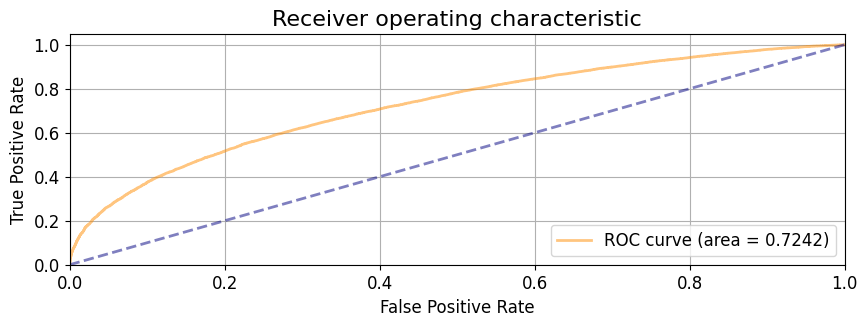

ROC-AUC Score:  0.7242346239675629
              precision    recall  f1-score   support

         0.0       0.42      0.72      0.53     14091
         1.0       0.85      0.61      0.71     35910

    accuracy                           0.64     50001
   macro avg       0.63      0.66      0.62     50001
weighted avg       0.72      0.64      0.66     50001

F1 Score:  0.7063495923098121


In [35]:
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_proba)
print("ROC-AUC Score: ", roc_auc)
print(classification_report(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

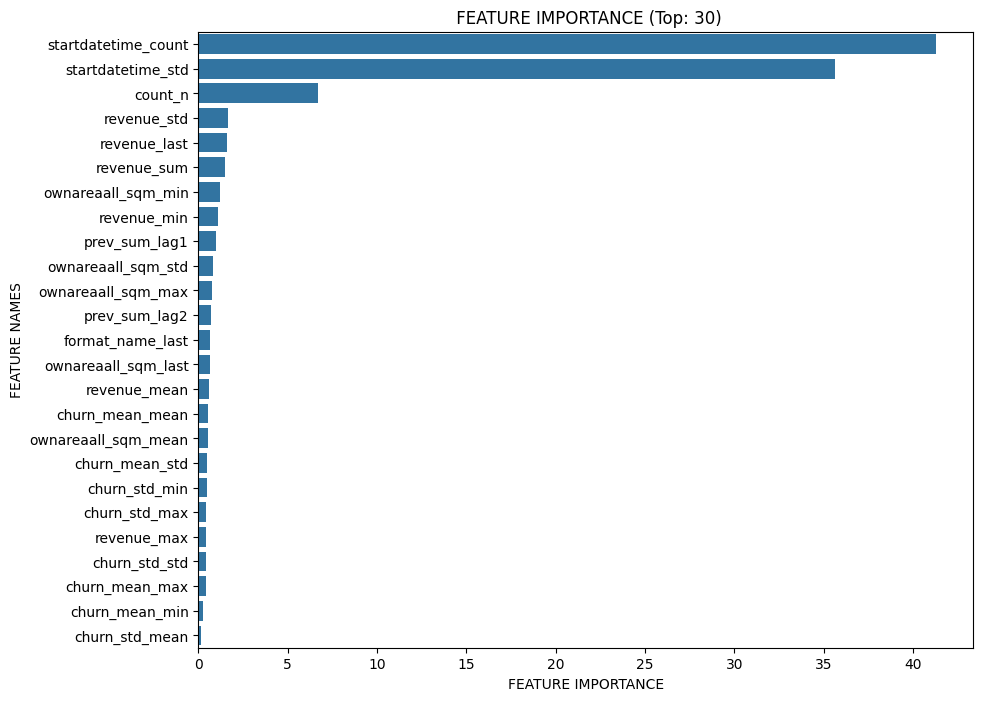

In [36]:
# Построение важности признаков
dfi = plot_feature_importance(model.get_feature_importance(), X_test.columns, top_n=30) 

## CatBoost Baseline | Регрессия времени до минимальной будущей транзакции

## Inference

In [39]:
# --- Baseline Features

# Считаем признаки через агрегации 
df_test = df_test.groupby("customer_id", as_index=False).agg(
    # Churn
    # churn=("buy_post", "last"),
    
    # Revenue
    revenue_mean=("revenue", "mean"),
    revenue_sum=("revenue", "sum"),
    revenue_max=("revenue", "max"),
    revenue_min=("revenue", "min"),
    revenue_std=("revenue", "std"),
    revenue_last=("revenue", "last"),

    # Area
    ownareaall_sqm_mean=("ownareaall_sqm", "mean"),
    ownareaall_sqm_max=("ownareaall_sqm", "max"),
    ownareaall_sqm_min=("ownareaall_sqm", "min"),
    ownareaall_sqm_std=("ownareaall_sqm", "std"),
    ownareaall_sqm_last=("ownareaall_sqm", "last"),

    # Format name
    format_name_last=("format_name", "last"),

    # StartDateTime
    startdatetime_count=("startdatetime", "count"),
    startdatetime_std=("startdatetime", "std"),
    # day_mean=("day_mean", "mean"),
    # day_std=("day_mean", "std"),
    # day_last=("day_mean", "last"),
    # day_of_week_mean=("day_of_week", "mean"),
    # day_of_week_std=("day_of_week", "std"),
    # day_of_week_last=("day_of_week", "last"),

    # Target Encoding
    churn_mean_mean=("churn_mean", "mean"),
    churn_mean_std=("churn_mean", "std"),
    churn_mean_min=("churn_mean", "min"),
    churn_mean_max=("churn_mean", "max"),

    churn_std_mean=("churn_std", "mean"),
    churn_std_std=("churn_std", "std"),
    churn_std_min=("churn_std", "min"),
    churn_std_max=("churn_std", "max"),
)
df_test['startdatetime_std'] = df_test['startdatetime_std'].dt.days
df_test = df_test.merge(test_customer_counts, how='left', on='customer_id')
df_test = df_test.merge(feat, how='left', on='customer_id')
df_test.shape

(112334, 26)

In [50]:
X_test_final = df_test[feature_columns]

assert X_test_final.shape[1] == X_train.shape[1], "Не совпадают размерности!"

In [51]:
df_test['churn_pred'] = model.predict(X_test_final)

In [52]:
submit = submit.merge(df_test[['customer_id', 'churn_pred']], how='left', on='customer_id')

In [53]:
submit['buy_post'] = submit['churn_pred']
submit = submit.drop(columns='churn_pred')

In [54]:
submit.to_csv("Baseline_GibData.csv", sep=';', index=False)

## Encemble

In [ ]:
scale_pos_weight = len(df_train[df_train['churn']==1])/len(df_train[df_train['churn']==0])
prc_weight = min(y_train.value_counts())/max(y_train.value_counts())
classifiers = [
               ['BalancedBaggingClassifier :', BalancedBaggingClassifier(n_estimators=200, max_samples=prc_weight, random_state=53)],
               ['EasyEnsembleClassifier :', EasyEnsembleClassifier(random_state=53)],
               ['ExtraTreesClassifier :', ExtraTreesClassifier(class_weight=class_weights, random_state=53)],"
               ['RandomForest :', RandomForestClassifier(n_estimators=200, class_weight=class_weights, random_state=53)],
               ['AdaBoostClassifier :', AdaBoostClassifier(random_state=53)],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier(random_state=53)],
               ['XGB :', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=53)],
               ['LGBM :', LGBMClassifier(scale_pos_weight=scale_pos_weight, verbose=-1, random_state=53)],
               ['CatBoost :', CatBoostClassifier(class_weights=class_weights, cat_features=cat_columns, verbose=False, random_state=53)]]


In [ ]:
# Разбиваем на фолды
cv_count = 4
prc_size_fold = 100/(cv_count+1)

current_size = 100
folds_list = []
# Объединяем трайн и вал. Тест остается тестом
all_folds = pd.concat([train_data, val_data])
for i in range(cv_count-1):
    current_size -= prc_size_fold
    all_folds, current_fold = split_by_client(all_folds, test_size=prc_size_fold/current_size)
    folds_list.append(current_fold)
    # Проверяем, что нет лика данных по клиентам между трайн/вал/тест
    assert len(set(all_folds["customer_id"])&set(current_fold["customer_id"])) == 0, "Лик train val"
    assert len(set(all_folds["customer_id"])&set(test_data["customer_id"])) == 0, "Лик train test"
    assert len(set(test_data["customer_id"])&set(current_fold["customer_id"])) == 0, "Лик test val"
    
folds_list.append(all_folds)

In [ ]:
%%time
# Обучаем k моделей
proba_predictions = []
for i in trange(cv_count):
    pool_train_data = folds_list.copy()
    
    val_data = pool_train_data.pop(i)
    train_data = pd.concat(pool_train_data)
    
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]

    X_val = val_data[feature_columns]
    y_val = val_data[target_column]

    # Проверяем, что нет лика данных по клиентам между трайн/вал/тест
    assert len(set(train_data["customer_id"]) & set(val_data["customer_id"])) == 0, "Лик train val"
    assert len(set(train_data["customer_id"]) & set(test_data["customer_id"])) == 0, "Лик train test"
    assert len(set(test_data["customer_id"]) & set(val_data["customer_id"])) == 0, "Лик test val"        
    
    for name, model in tqdm(classifiers):
        print(name)
        model.fit(X_train, y_train)  # Предполагается, что X_train и y_train подготовлены
        y_pred = model.predict(X_test)
        metrics_classifie(y_test, y_pred, model, name)
        proba_predictions.append(model.predict_proba(X_test))
    
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape)
